In [1]:
"""
Created on Tue Oct  1 14:53:35 2020

@author: Erdos1729
"""

import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

from keras.datasets import reuters
from keras.datasets import imdb
from sklearn.datasets import fetch_20newsgroups

import pandas as pd
import pandas_profiling as pp

from matplotlib import pyplot as plt
import seaborn as sns
import os
import string
import re

import numpy as np
# !pip install nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
import runpy
import time

print(os.listdir('./data_files'))

##### Please select the dataset you want to work on #####

datasets = ['reuters_data.csv', 'imdb_data.csv', 'webofscience_data.csv', 'newsgroup']
data = datasets[0]

path = "download_" + data.replace("_data.csv",".py")
print("\n" + "Working on " + data.replace(".csv",""))
time.sleep(5)

if data not in os.listdir('./data_files'):
    if "imdb" in data:
        import download_imdb
        runpy.run_path(path_name=path)
    elif "reuters" in data:
        import download_reuters
        runpy.run_path(path_name=path)
    elif "webofscience_data" in data:
        import download_webscience
        runpy.run_path(path_name=path)
    else:
        print("Download not required for the dataset")
else:
    print("\n" + data.replace(".csv","") + " data downloaded")

['20_ng', '20_ng.tar.gz', '9rw3vkcfy4-2.zip', 'aclImdb', 'aclImdb_v1.tar.gz', 'imdb_data.csv', 'mini_ng.tar.gz', 'reuters_data.csv', 'WebofScience', 'webofscience_data.csv']

Working on reuters_data

reuters_data data downloaded


In [3]:
print("Pre-text processing")

def text_clean1(text):
    textclean = []
    gibber = ["/", " / ", "#", "*", "&", " in ", " and ", " of ", " for "]
    for i in text:
        i = i.lower()
        # print(i)
        for ch in string.punctuation:
            i = i.replace(ch, " ")
        for x in gibber:
            i = i.replace(x, " ")
        i = i.strip()
        i = " ".join(i.split())
        textclean.append(i)
    return textclean


def text_clean(text):
    textclean = []

    gibber = ["null", " nan "]
    rules = [
        {r'>\s+': u'>'},  # remove spaces after a tag opens or closes
        {r'\s+': u' '},  # replace consecutive spaces
        {r'\s*<br\s*/?>\s*': u'\n'},  # newline after a <br>
        {r'</(div)\s*>\s*': u'\n'},  # newline after </p> and </div> and <h1/>...
        {r'</(p|h\d)\s*>\s*': u'\n\n'},  # newline after </p> and </div> and <h1/>...
        {r'<head>.*<\s*(/head|body)[^>]*>': u''},  # remove <head> to </head>
        {r'<a\s+href="([^"]+)"[^>]*>.*</a>': r'\1'},  # show links instead of texts
        {r'[ \t]*<[^<]*?/?>': u''},  # remove remaining tags
        {r'^\s+': u''}  # remove spaces at the beginning
    ]
    stop_words = set(stopwords.words('english'))
    not_stopwords = {"up", "down", "Up", "Down"}
    stop_words = set([word for word in stop_words if word not in not_stopwords])
    regEx = r'(?:\d{1,2}[/]\d{1,2}[/]\d{2,4})|(?:\d{1,2}[-]\d{1,2}[-]\d{2,4})|(?:\d{1,2}[\s]\d{1,2}[\s]\d{2,4})|(?:\d{1,2}[-/th|st|nd|rd\s]*)?(?:Jan+|Feb+|Mar+|Apr+|May+|Jun+|Jul+|Aug+|Sep+|Oct+|Nov+|Dec+)[a-z\s,.]*(?:\d{1,2}[-/th|st|nd|rd)\s,]*)?(?:\d{2,4})'

    for i in text:  # print(i)
        i = i.replace(".00", " ")
        result = re.findall(regEx, i)
        for item in result:
            i = i.replace(item, "")  # Removes dates from text

        i = i.lower()
        # print(i)
        for ch in string.punctuation:  # removes punctuations from all the lines
            if ch == "/" or ch == "-":
                if "-1/" in i or "1/" in i:
                    i = i
                else:
                    i = i.replace(ch, " ")
            else:
                i = i.replace(ch, " ")

        # i = i.strip()
        # i = " ".join(i.split())
        for x in gibber:
            # print(i)
            i = i.replace(x, " ")
        for rule in rules:
            for (k, v) in rule.items():
                regex = re.compile(k)
                i = regex.sub(v, i)

        i = re.sub(r'(\d+)\s+(\d+)\s|(\d{3})\s(\d{3})', r'\1\2', i)

        word_tokens = word_tokenize(i)
        # filtered_sentence = [w for w in word_tokens if not w in stop_words]
        token_sentence = []
        for w in word_tokens:
            if w not in stop_words:  # To remove all stopwords from the text
                token_sentence.append(w)
        # token_sentence = list(unique_everseen(token_sentence)) #To remove duplicates in the list
        i = " ".join([w for w in token_sentence])
        # i = ''.join([l for l in i if not l.isdigit()]) # Removes all the numerics from string
        i = re.sub(' +', ' ', i)  # removes extra spaces from the entire string
        i = i.strip()
        textclean.append(i)

    return textclean


Pre-text processing


In [4]:
if "newsgroup" in data:
    print("Data directly accessed online")
else:
    df = pd.read_csv('./data_files/' + data)
    text = df['Text'].values.astype(str)
    label = df['Label'].values
    textclean = text_clean(text)
    print("\n", textclean)
    df.info()
    pp.ProfileReport(df)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
if 'reuters' in data:
    X_train, X_test, y_train, y_test = train_test_split(textclean, label, test_size=0.50)

elif 'imdb' in data:
    is_train = df['Type']=='train'
    df_train = df[is_train]
    X_train, y_train = df_train['Text'].values.astype(str), df_train['Label'].values
    is_test = df['Type']=='test'
    df_test = df[is_test]
    X_test, y_test = df_test['Text'].values.astype(str), df_test['Label'].values

elif 'webofscience' in data:
    X_train, X_test, y_train, y_test = train_test_split(textclean, label, test_size=0.50)
    
elif 'news' in data:
    newsgroups_train = fetch_20newsgroups(subset='train')
    newsgroups_test = fetch_20newsgroups(subset='test')
    X_train = newsgroups_train.data
    X_test = newsgroups_test.data
    y_train = newsgroups_train.target
    y_test = newsgroups_test.target
    df = pd.DataFrame()
    print(y_train)
    y_new = [int(i) for i in y_train] + [int(n) for n in y_test]
    df['Label'] = y_new

#### LinearSVC

In [6]:
svc_mod = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
                     ])

svc_mod.fit(X_train, y_train)
predicted = svc_mod.predict(X_test)

# Analyze model metrics
print("Linear SVC Classification Report")
print(metrics.classification_report(y_test, predicted))

print("Linear SVC Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted))

Linear SVC Classification Report
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        35
           1       0.79      0.83      0.81       276
           2       0.76      0.62      0.68        47
           3       0.92      0.94      0.93      1946
           4       0.84      0.91      0.87      1203
           5       0.00      0.00      0.00        12
           6       0.90      0.88      0.89        32
           7       0.88      0.64      0.74        11
           8       0.65      0.49      0.56        84
           9       0.92      0.83      0.88        59
          10       0.81      0.87      0.84        69
          11       0.70      0.75      0.72       242
          12       0.64      0.56      0.60        32
          13       0.73      0.73      0.73       106
          14       0.67      0.67      0.67        12
          15       0.43      0.17      0.24        18
          16       0.69      0.79      0.74     

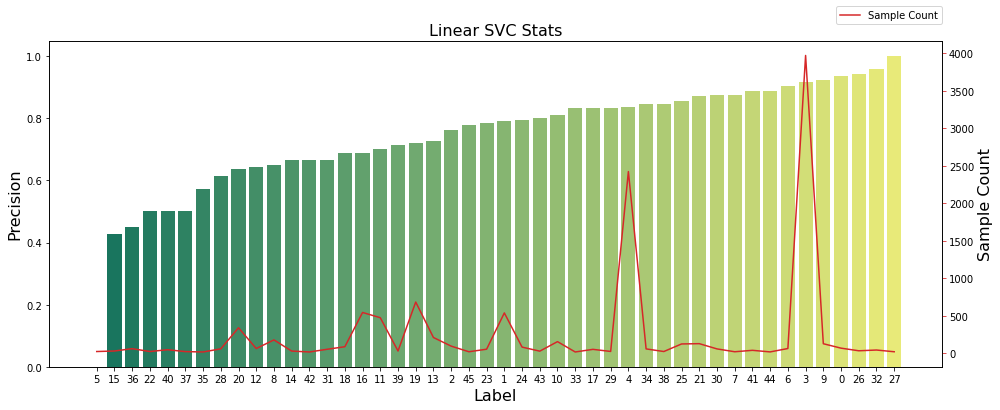

In [7]:
labels = df['Label'].unique()
labels.sort()

lab = df['Label'].values.astype(int)
check = []
for i in lab:
    check.append(i)

support = []
for i in labels:
    support.append(check.count(i))

df1 = pd.DataFrame()
df1['Label'] = labels
df1['Label'] = df1['Label'].astype(str)
df1['Sample Count'] = support

df11 = df1
precision = precision_score(y_test, predicted, average=None)
df11['Precision'] = precision
df11 = df1.sort_values(by=['Precision'])

#Create combo chart
fig, ax1 = plt.subplots(figsize=(16,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Linear SVC Stats', fontsize=16)
ax1.set_xlabel('Label', fontsize=16)
ax1.set_ylabel('Precision', fontsize=16)
ax1 = sns.barplot(df11['Label'], df11['Precision'], palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Sample Count', fontsize=16)
ax2 = sns.lineplot(df11['Label'], df11['Sample Count'], sort=True, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.legend(bbox_to_anchor=(1, 1.05), loc=4, borderaxespad=0., labels=['Sample Count'])
plt.show()

#### BaggingKNN

In [8]:
Bknn_mod = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', BaggingClassifier(KNeighborsClassifier())),
                     ])

Bknn_mod.fit(X_train, y_train)
predicted = Bknn_mod.predict(X_test)

# Analyze model metrics
print("Bagging KNN Classification Report")
print(metrics.classification_report(y_test, predicted))

print("Bagging KNN Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted))

Bagging KNN Classification Report
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        35
           1       0.67      0.77      0.72       276
           2       0.58      0.60      0.59        47
           3       0.85      0.93      0.89      1946
           4       0.84      0.77      0.80      1203
           5       0.14      0.08      0.11        12
           6       0.77      0.72      0.74        32
           7       0.75      0.82      0.78        11
           8       0.64      0.44      0.52        84
           9       0.86      0.81      0.83        59
          10       0.77      0.74      0.76        69
          11       0.63      0.62      0.63       242
          12       0.50      0.44      0.47        32
          13       0.69      0.60      0.64       106
          14       0.57      0.67      0.62        12
          15       0.33      0.17      0.22        18
          16       0.64      0.74      0.68    

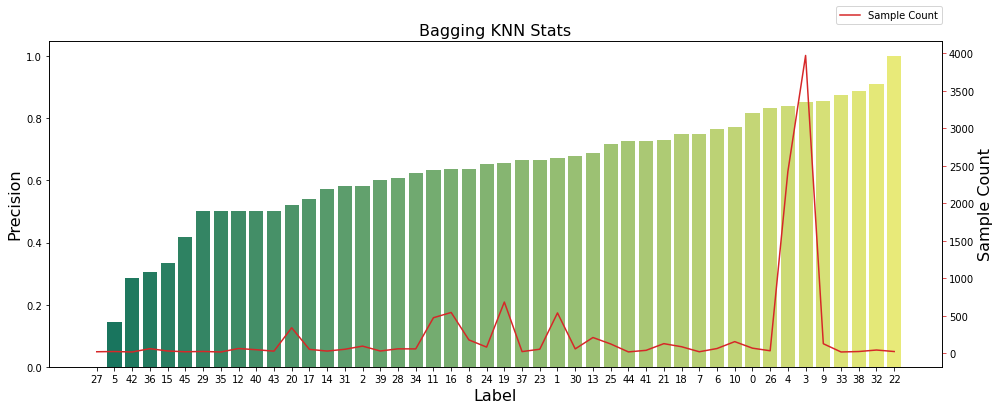

In [9]:
df12 = df1
precision = precision_score(y_test, predicted, average=None)
df12['Precision'] = precision
df12 = df1.sort_values(by=['Precision'])

#Create combo chart
fig, ax1 = plt.subplots(figsize=(16,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Bagging KNN Stats', fontsize=16)
ax1.set_xlabel('Label', fontsize=16)
ax1.set_ylabel('Precision', fontsize=16)
ax1 = sns.barplot(df12['Label'], df12['Precision'], palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Sample Count', fontsize=16)
ax2 = sns.lineplot(df12['Label'], df12['Sample Count'], sort=True, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.legend(bbox_to_anchor=(1, 1.05), loc=4, borderaxespad=0., labels=['Sample Count'])
plt.show()

#### Gradient Boosting

In [10]:
GB_mod = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(n_estimators=50,verbose=2)),
                     ])

GB_mod.fit(X_train, y_train)
predicted = GB_mod.predict(X_test)

# Analyze model metrics
print("Gradient Boosting Classification Report")
print(metrics.classification_report(y_test, predicted))

print("Gradient Boosting Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted))

      Iter       Train Loss   Remaining Time 
         1           1.4178            9.32m
         2        2367.9642            9.47m
         3        2466.0767            9.22m
         4 27308168841610245554519156100563344455209277598601077893408061329199274817026707331397680365568.0000            8.93m
         5 27308168841610245554519156100563344455209277598601077893408061329199274817026707331397680365568.0000            8.74m
         6 27308168841610245554519156100563344455209277598601077893408061329199274817026707331397680365568.0000            8.58m
         7 27308168841610245554519156100563344455209277598601077893408061329199274817026707331397680365568.0000            8.38m
         8 27308168841610245554519156100563344455209277598601077893408061329199274817026707331397680365568.0000            8.15m
         9 27308168841610245554519156100563344455209277598601077893408061329199274817026707331397680365568.0000            7.96m
        10 2730816884161024555451915610056334

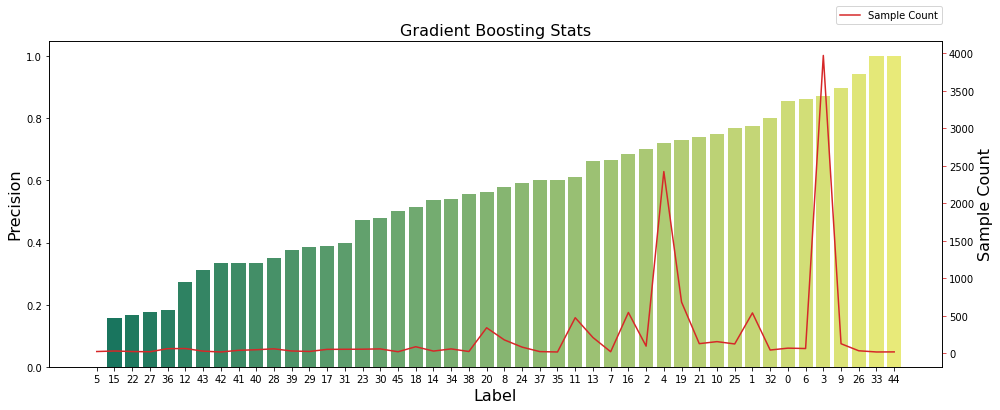

In [11]:
df13 = df1
precision = precision_score(y_test, predicted, average=None)
df13['Precision'] = precision
df13 = df1.sort_values(by=['Precision'])

#Create combo chart
fig, ax1 = plt.subplots(figsize=(16,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Gradient Boosting Stats', fontsize=16)
ax1.set_xlabel('Label', fontsize=16)
ax1.set_ylabel('Precision', fontsize=16)
ax1 = sns.barplot(df13['Label'], df13['Precision'], palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Sample Count', fontsize=16)
ax2 = sns.lineplot(df13['Label'], df13['Sample Count'], sort=True, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.legend(bbox_to_anchor=(1, 1.05), loc=4, borderaxespad=0., labels=['Sample Count'])
plt.show()

#### Random Forest

In [12]:
RF_mod = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=100)),
                     ])

RF_mod.fit(X_train, y_train)
predicted = RF_mod.predict(X_test)

# Analyze model metrics
print("Random Forest Classification Report")
print(metrics.classification_report(y_test, predicted))

print("Random Forest Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.88      0.20      0.33        35
           1       0.65      0.77      0.71       276
           2       0.79      0.32      0.45        47
           3       0.85      0.90      0.87      1946
           4       0.61      0.94      0.74      1203
           5       0.00      0.00      0.00        12
           6       1.00      0.31      0.48        32
           7       1.00      0.36      0.53        11
           8       0.71      0.40      0.52        84
           9       0.92      0.58      0.71        59
          10       0.81      0.30      0.44        69
          11       0.69      0.62      0.66       242
          12       0.67      0.06      0.11        32
          13       0.62      0.15      0.24       106
          14       0.67      0.17      0.27        12
          15       1.00      0.06      0.11        18
          16       0.66      0.73      0.69  

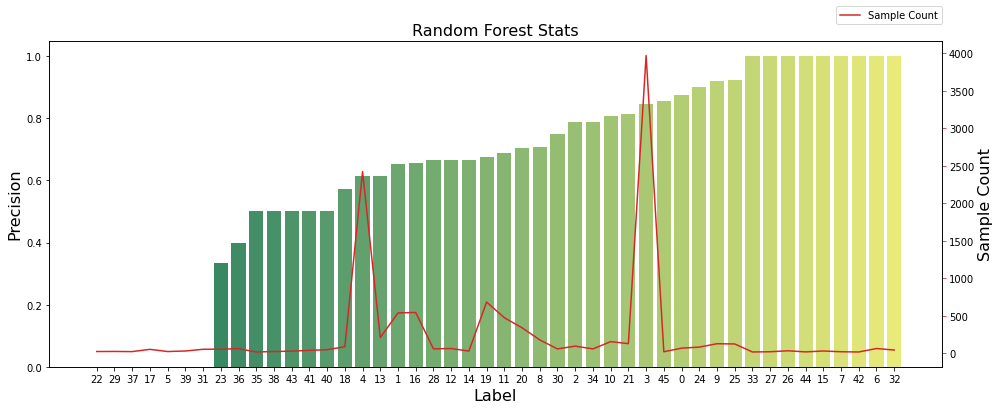

In [13]:
df14 = df1
precision = precision_score(y_test, predicted, average=None)
df14['Precision'] = precision
df14 = df1.sort_values(by=['Precision'])

#Create combo chart
fig, ax1 = plt.subplots(figsize=(16,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Random Forest Stats', fontsize=16)
ax1.set_xlabel('Label', fontsize=16)
ax1.set_ylabel('Precision', fontsize=16)
ax1 = sns.barplot(df14['Label'], df14['Precision'], palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Sample Count', fontsize=16)
ax2 = sns.lineplot(df14['Label'], df14['Sample Count'], sort=True, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.legend(bbox_to_anchor=(1, 1.05), loc=4, borderaxespad=0., labels=['Sample Count'])
plt.show()

#### KNN

In [14]:
knn_mod = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier()),
                     ])

knn_mod.fit(X_train, y_train)
predicted = knn_mod.predict(X_test)

# Analyze model metrics
print("KNN Classification Report")
print(metrics.classification_report(y_test, predicted))

print("KNN Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted))

KNN Classification Report
              precision    recall  f1-score   support

           0       0.69      0.89      0.78        35
           1       0.61      0.80      0.69       276
           2       0.54      0.60      0.57        47
           3       0.83      0.94      0.88      1946
           4       0.84      0.75      0.79      1203
           5       0.14      0.08      0.11        12
           6       0.75      0.75      0.75        32
           7       0.75      0.82      0.78        11
           8       0.59      0.45      0.51        84
           9       0.82      0.78      0.80        59
          10       0.68      0.65      0.67        69
          11       0.65      0.62      0.63       242
          12       0.42      0.31      0.36        32
          13       0.72      0.58      0.65       106
          14       0.64      0.58      0.61        12
          15       0.30      0.17      0.21        18
          16       0.66      0.73      0.69       264
 

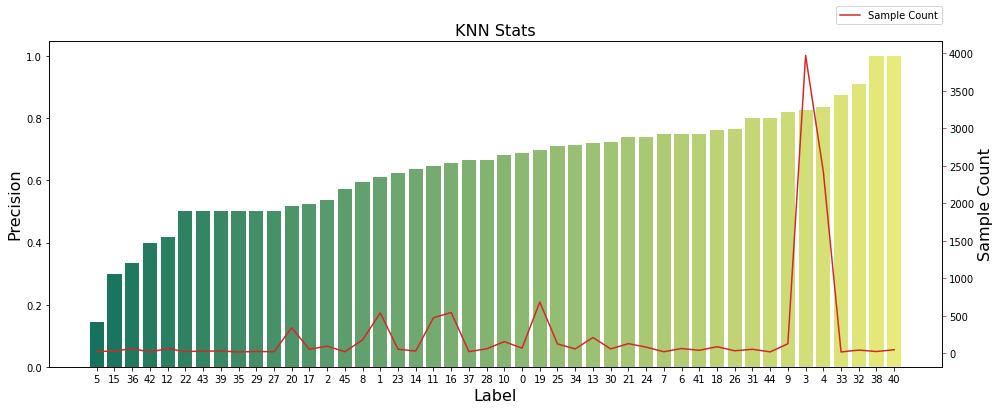

In [15]:
df15 = df1
precision = precision_score(y_test, predicted, average=None)
df15['Precision'] = precision
df15 = df1.sort_values(by=['Precision'])

#Create combo chart
fig, ax1 = plt.subplots(figsize=(16,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('KNN Stats', fontsize=16)
ax1.set_xlabel('Label', fontsize=16)
ax1.set_ylabel('Precision', fontsize=16)
ax1 = sns.barplot(df15['Label'], df15['Precision'], palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Sample Count', fontsize=16)
ax2 = sns.lineplot(df15['Label'], df15['Sample Count'], sort=True, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.legend(bbox_to_anchor=(1, 1.05), loc=4, borderaxespad=0., labels=['Sample Count'])
plt.show()

#### Decision Tree

In [16]:
DT_mod = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', tree.DecisionTreeClassifier()),
                     ])

DT_mod.fit(X_train, y_train)
predicted = DT_mod.predict(X_test)

# Analyze model metrics
print("Decision Tree Classification Report")
print(metrics.classification_report(y_test, predicted))

print("Decision Tree Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted))

Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.76      0.71      0.74        35
           1       0.63      0.62      0.63       276
           2       0.39      0.36      0.37        47
           3       0.85      0.86      0.85      1946
           4       0.73      0.77      0.75      1203
           5       0.06      0.08      0.07        12
           6       0.66      0.66      0.66        32
           7       0.80      0.36      0.50        11
           8       0.37      0.37      0.37        84
           9       0.86      0.71      0.78        59
          10       0.34      0.41      0.37        69
          11       0.51      0.54      0.52       242
          12       0.23      0.34      0.27        32
          13       0.32      0.35      0.33       106
          14       0.45      0.42      0.43        12
          15       0.12      0.11      0.11        18
          16       0.53      0.58      0.55  

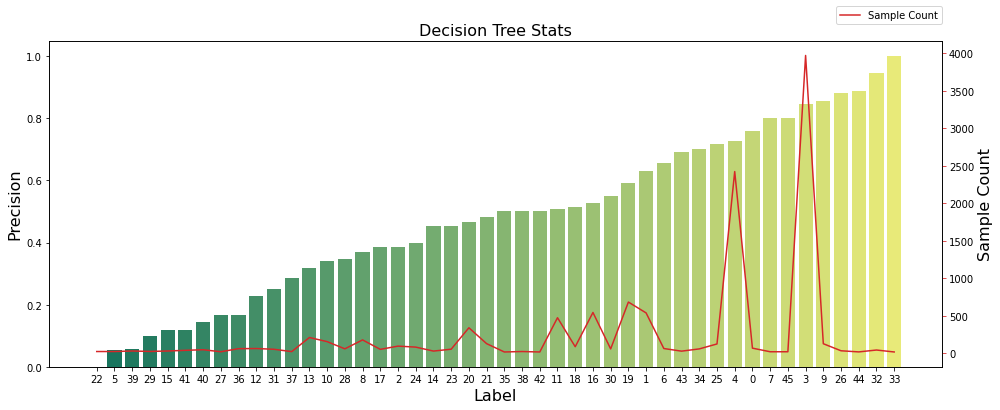

In [17]:
df16 = df1
precision = precision_score(y_test, predicted, average=None)
df16['Precision'] = precision
df16 = df1.sort_values(by=['Precision'])

#Create combo chart
fig, ax1 = plt.subplots(figsize=(16,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Decision Tree Stats', fontsize=16)
ax1.set_xlabel('Label', fontsize=16)
ax1.set_ylabel('Precision', fontsize=16)
ax1 = sns.barplot(df16['Label'], df16['Precision'], palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Sample Count', fontsize=16)
ax2 = sns.lineplot(df16['Label'], df16['Sample Count'], sort=True, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.legend(bbox_to_anchor=(1, 1.05), loc=4, borderaxespad=0., labels=['Sample Count'])
plt.show()

#### Multinomial Naive Bayes

In [18]:
MNB_mod = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])

MNB_mod.fit(X_train, y_train)
predicted = MNB_mod.predict(X_test)

# Analyze model metrics
print("Multinomial Naive Bayes Classification Report")
print(metrics.classification_report(y_test, predicted))

print("Multinomial Naive Bayes Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted))

Multinomial Naive Bayes Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.79      0.15      0.25       276
           2       0.00      0.00      0.00        47
           3       0.65      0.94      0.77      1946
           4       0.46      0.93      0.61      1203
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00        32
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        84
           9       0.00      0.00      0.00        59
          10       0.00      0.00      0.00        69
          11       0.85      0.14      0.24       242
          12       0.00      0.00      0.00        32
          13       0.00      0.00      0.00       106
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        18
          16       0.75      0.14  

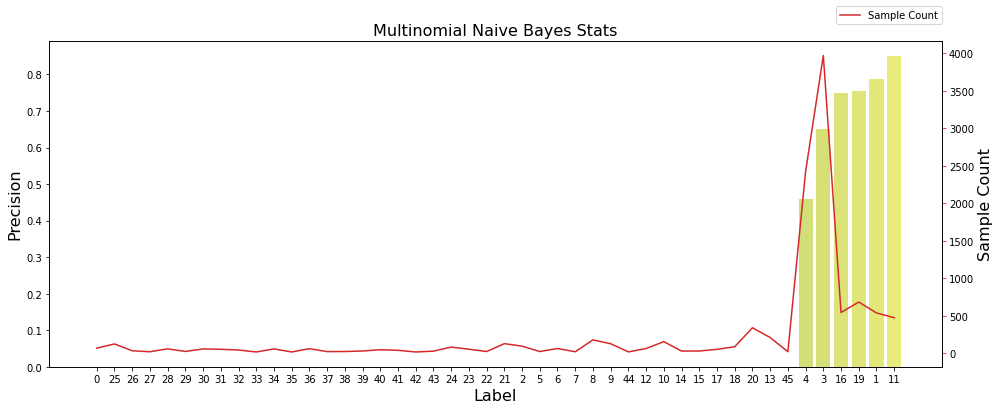

In [19]:
df17 = df1
precision = precision_score(y_test, predicted, average=None)
df17['Precision'] = precision
df17 = df1.sort_values(by=['Precision'])

#Create combo chart
fig, ax1 = plt.subplots(figsize=(16,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Multinomial Naive Bayes Stats', fontsize=16)
ax1.set_xlabel('Label', fontsize=16)
ax1.set_ylabel('Precision', fontsize=16)
ax1 = sns.barplot(df17['Label'], df17['Precision'], palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Sample Count', fontsize=16)
ax2 = sns.lineplot(df17['Label'], df17['Sample Count'], sort=True, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.legend(bbox_to_anchor=(1, 1.05), loc=4, borderaxespad=0., labels=['Sample Count'])
plt.show()

#### Rocchio Nearest Centroid

In [20]:
RNC_mod = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', NearestCentroid()),
                     ])

RNC_mod.fit(X_train, y_train)
predicted = RNC_mod.predict(X_test)

# Analyze model metrics
print("Rocchio Nearest Centroid Classification Report")
print(metrics.classification_report(y_test, predicted))

print("Rocchio Nearest Centroid Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted))

Rocchio Nearest Centroid Classification Report
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        35
           1       0.79      0.71      0.75       276
           2       0.63      0.68      0.65        47
           3       0.96      0.73      0.83      1946
           4       0.63      0.92      0.75      1203
           5       0.20      0.17      0.18        12
           6       0.86      0.75      0.80        32
           7       0.88      0.64      0.74        11
           8       0.51      0.44      0.47        84
           9       0.94      0.81      0.87        59
          10       0.73      0.81      0.77        69
          11       0.57      0.67      0.61       242
          12       0.59      0.72      0.65        32
          13       0.61      0.86      0.71       106
          14       0.69      0.75      0.72        12
          15       0.60      0.17      0.26        18
          16       0.72      0.73 

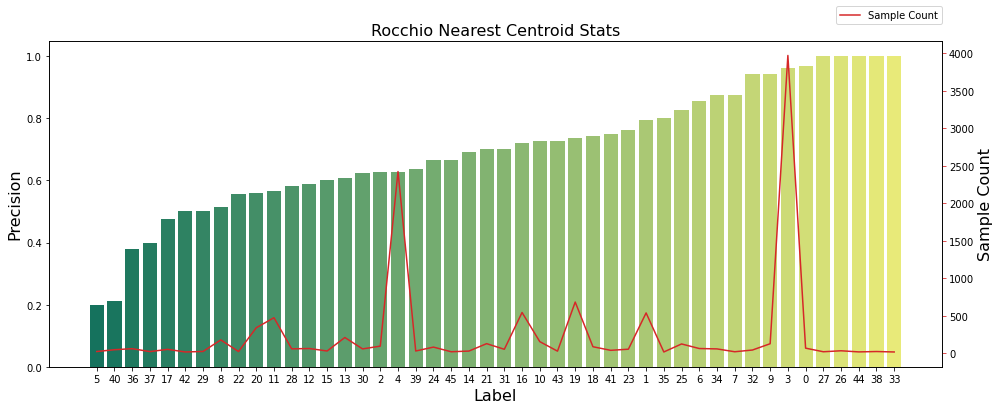

In [21]:
df18 = df1
precision = precision_score(y_test, predicted, average=None)
df18['Precision'] = precision
df18 = df1.sort_values(by=['Precision'])

#Create combo chart
fig, ax1 = plt.subplots(figsize=(16,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Rocchio Nearest Centroid Stats', fontsize=16)
ax1.set_xlabel('Label', fontsize=16)
ax1.set_ylabel('Precision', fontsize=16)
ax1 = sns.barplot(df18['Label'], df18['Precision'], palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Sample Count', fontsize=16)
ax2 = sns.lineplot(df18['Label'], df18['Sample Count'], sort=True, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.legend(bbox_to_anchor=(1, 1.05), loc=4, borderaxespad=0., labels=['Sample Count'])
plt.show()